# Identify working and data directory and site ID.
* The working directory is the root directory of the github.
* The data directory points to the google drive folder where the larger data files are stored.
* For the moment the site ID if the four-digit NEON site ID.

In [1]:
working<-"~/neon_suna"

working_data<-"/Users/jhosen/gdrive/SUNA_Data/"
save<-paste(working_data,"/corrected_files/",sep="")

site_id<-"PLRA"
#data<-paste("~/gdrive/SUNA_Data/SUNA_NEON/",site_id,"/2019",sep="")
data<-"/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/PLRA_2019"

# Initialize required libraries, functions and formatting utilities.

In [2]:
library(dplyr)
library(streamMetabolizer)
library(splitstackshape)
library(ggplot2)
library(lubridate)
library(reshape2)
library(neonUtilities)
library(progress)
library(patchwork)
library(doBy)
library(stringr)
#library(box)

theme_ts_space<-theme_grey() +
		theme(
#		panel.grid.major = element_blank(),
#		panel.grid.minor = element_blank(),
		panel.background = element_rect(fill="white", colour="black", size=2),
#		legend.key       = element_blank(),
#		legend.text      = element_text(size=20.5),
#		legend.text      = element_blank(),
#		legend.title     = element_text(size=20.5),
		axis.text.x = element_text(size=22,colour="black",hjust=1,angle=45),
		axis.text.y = element_text(size=22,colour="black",vjust=.3),
		axis.title.x = element_text(size=22),
		axis.title.y = element_text(size=22,vjust=-1),
#		plot.title = element_text(hjust = 0.5,size=22,face="bold"),		
#		legend.position  = "left",
		legend.position  = "none",
		plot.margin = unit(c(1,1,1,1), "cm"),
		panel.border = element_rect(colour = "black", fill=NA, size=2)
		)






Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


USGS Active Research Package:
https://owi.usgs.gov/R/packages.html#research

This package was developed for research purposes. We used it for our
own applications and welcome flexible, resilient users who can help us
test and improve the package. Please give us feedback at
https://github.com/USGS-R/streamMetabolizer/issues/new.


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘doBy’


The following object is masked from ‘package:dplyr’:

    order_by




# Setting up the workspace
In the cell below indicate the site that will be analyzed here according to its NEON 4-letter code. A list of files for that site is then placed in the vector "sunas".

If you downloaded the repo into your home director, which is found by going to "~/", then you don"t have to change the box path. FYI: Box is a new package for R that allows you to define a set of functions without creating a new package.

In [3]:

#setwd(paste("~/gdrive/SUNA_data/SUNA_NEON/",site_id,sep=""))
#sunas<-list.files(pattern="*.csv")
#getwd()
#options(box.path = "~/neon_suna/box/")
#box::use(plots)

setwd(data)
sunas<-list.files(pattern="*.CSV")

#suna_cal<-readRDS("/Users/jhosen/gdrive/fdom/SUNA Calibration pdfs/suna_cal_comb.rds")
suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA Calibration pdfs/suna_0839_20200312.csv")
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]

# Data import and processing loop.
This step loads each data file, formats the data for use, and concatenates files from an individual site.

This step could take a while.

In [9]:
cal

[1] "SNA1177H"

In [11]:
options(warn=-1)
compiled_suna<-data.frame()
sunas_length<-length(sunas)
for(i in 1:sunas_length){
#i<-1
print(i)


suna_calid<-read.csv(paste(sunas[i]),skip=0,header=FALSE)
cal<-str_extract(suna_calid,"[SNA]{3}[0-9]{4}[a-zA-Z]{1}")
cal<-cal[!is.na(cal)]
    
    
suna<-read.csv(paste(sunas[i]),skip=30,header=FALSE)

if(cal!="SNA1177F" & cal!="SNA1177G" & cal!="SNA1177H"){suna_cal<-read.csv(paste("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/PLRA_2019/cal_files/",cal,"_abbr.csv",sep=""))}else{
    suna_cal<-read.csv("/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/PLRA_2019/cal_files/SNA1177E_abbr.csv")}



    
    
suna_cal_t<-as.data.frame(t(suna_cal))
names(suna_cal_t)<-suna_cal_t[1,]

#suna_d0<-cSplit(suna,3, ",")
names(suna)<-c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time",suna_cal$wavelength_nm,"sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum")

    
#suna<-subset(suna,a254!=0)

suna<-subset(suna,a254!=0)
    
#year<-substr(suna$date, 1, 4)
if(grepl("D2019",sunas[i])==TRUE){
year<-"2019"
doy<-gsub(".CSV","",gsub("D2019","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}
    
if(grepl("D2020",sunas[i])==TRUE){
year<-"2020"
doy<-gsub(".CSV","",gsub("D2020","",paste(sunas[i]),fixed=TRUE),fixed=TRUE)
}

day<-as.POSIXct(paste(as.Date(as.numeric(doy)-1,origin=paste(year,"-01-01",sep="")),"00:00:00"),tz="UTC")
#suna$day<-as.POSIXct("2019-05-10 00:00:00",tz="UTC")
suna$dtp<-day + (3600*as.numeric(suna$time))
#attr(suna$dtp,"tzone") <- "Etc/GMT+8"

    

offse<-c(t(suna_cal_t[3,]))
suna2<-(suna[,12:267]/suna$int_time)-suna$dark_signal_average
suna_d0_norm<-sweep(suna2,2,FUN="/",offse)
names(suna_d0_norm)<-paste("n_",names(suna_cal_t),sep="")

    

#print("test")
suna_d0_int<-data.frame()
for(j in 1:nrow(suna_d0_norm)){	
#    print(j)
    if(!is.na(suna_d0_norm[j,1])){
	flip<-as.data.frame(t(suna_d0_norm[j,]))
	names(flip)<-c("abs")
	flip$wl_nm<-gsub("n_","",row.names(flip),fixed=TRUE)
	flip_int<-as.data.frame(t(approx(flip$wl_nm,flip$abs,xout=seq(189,394,1),rule=2)$y))
	names(flip_int)<-paste("interp_",seq(189,394,1),sep="")
	suna_d0_int<-bind_rows(suna_d0_int,flip_int)
    }else{
        flip_int[1,]<-NA
       	suna_d0_int<-bind_rows(suna_d0_int,flip_int)
    }
}
suna_d<-bind_cols(suna,suna_d0_int)
#suna_d$date<-as.character(suna_d[,c("date")])
#suna_d$time<-as.character(suna_d[,c("time")])
suna_d2<-suna_d %>% mutate_if(is.numeric,as.character)
compiled_suna<-bind_rows(compiled_suna,suna_d2)
}
print("done")
options(warn=0)    
    
    
    


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 

# Check Data and Save

In [4]:
#head(compiled_suna)
#grepl("D2020",sunas[240])
#sunas[240]
#length(sunas)
#sunas[240]
#ncol(compiled_suna)
#nrow(compiled_suna)
#names(compiled_suna)<-gsub("inter_time","int_time",names(compiled_suna),fixed=TRUE)
#saveRDS(compiled_suna,"/Users/jhosen/gdrive/SUNA_Data/corrected_files/SUNA_Cor/SUNA_PLRA_20210428_full.rds")
compiled_suna<-readRDS("/Users/jhosen/gdrive/SUNA_Data/corrected_files/SUNA_Cor/SUNA_PLRA_20210428_full.rds")


# Extracting the interpolated columns

In [6]:
compiled_suna$cal<-"suna_0839"

suna_interp<-compiled_suna[,grepl("^inter",names(compiled_suna))] %>% mutate_if(is.character, ~as.numeric(.))
#head(suna_interp)

other_suna<-compiled_suna[,c("suna_id","date","time","nitrate","nitrate_mgl","a254","a350","bromide_trace","spec_average_dark","dark_signal_average","int_time","sensor_temp","spec_temp","lamp_temp","lamp_time","rel_hum","main_volt","lamp_volt","int_volt","main_current","fit_aux_1","fit_aux_2","fit_base_1","fit_base_2","fit_RMSE","CTD_Time","CTD_Salinity","CTD_Temp","CTD_Pressure","checksum","cal","dtp")]

suna_cols<-bind_cols(other_suna,suna_interp)
suna_cols$a254<-as.numeric(suna_cols$a254)
suna_cols$a350<-as.numeric(suna_cols$a350)
suna_cols$nitrate<-as.numeric(suna_cols$nitrate)
suna_cols$nitrate_mgl<-as.numeric(suna_cols$nitrate_mgl)
suna_cols$sensor_temp<-as.numeric(suna_cols$sensor_temp)


In [7]:
range(suna_cols$a254)
range(suna_cols$interp_254)

[1] -0.0535 99.0000

[1] NA NA

In [8]:
suna_cols<-subset(suna_cols,a350<10 & a254<10)
a350_mod<-lm(a350~log10(interp_350)+I(log10(interp_350)^2)+I(log10(interp_350)^3),suna_cols)
a254_mod<-lm(a254~log10(interp_254+0.6)+I(log10(interp_254+0.6)^2)+I(log10(interp_254+0.6)^3),suna_cols)



cor_cols<-grep("^interp_",names(suna_cols))



Call:
lm(formula = a254 ~ log10(interp_254 + 0.6) + I(log10(interp_254 + 
    0.6)^2) + I(log10(interp_254 + 0.6)^3), data = suna_cols)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18906 -0.00650 -0.00022  0.00569  1.13850 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   4.775e-01  6.078e-05  7856.0   <2e-16 ***
log10(interp_254 + 0.6)      -1.280e+00  1.618e-03  -791.2   <2e-16 ***
I(log10(interp_254 + 0.6)^2)  5.899e+00  7.012e-03   841.2   <2e-16 ***
I(log10(interp_254 + 0.6)^3) -4.132e+01  5.892e-02  -701.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.01201 on 282263 degrees of freedom
  (69 observations deleted due to missingness)
Multiple R-squared:  0.9832,	Adjusted R-squared:  0.9832 
F-statistic: 5.51e+06 on 3 and 282263 DF,  p-value: < 2.2e-16


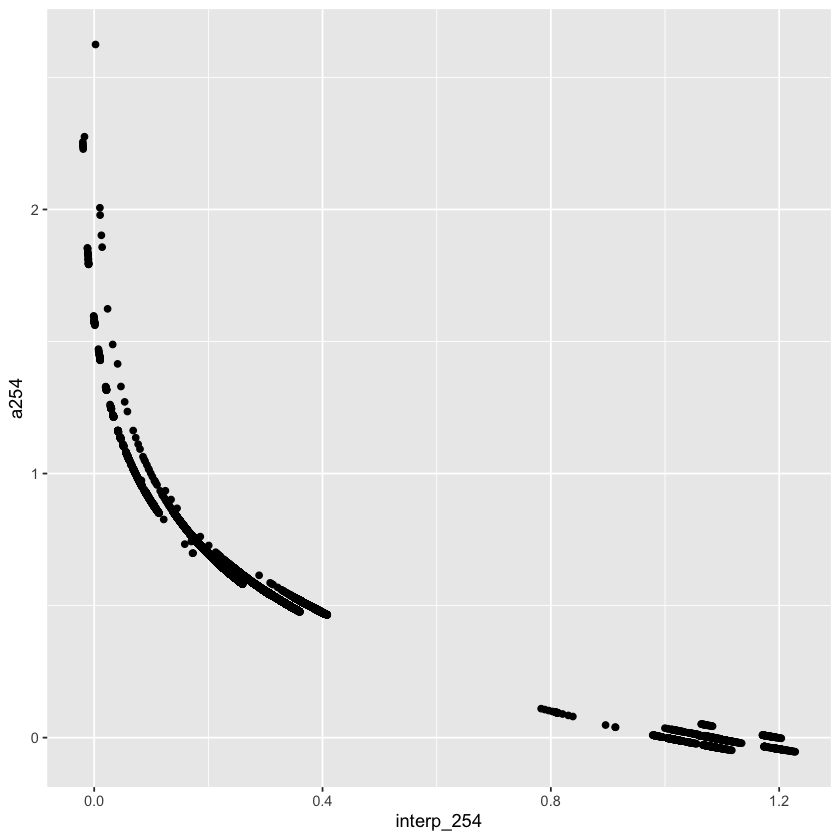

In [9]:
ggplot(suna_cols,aes(interp_254,a254))+geom_point()

summary(a254_mod)

In [10]:

options(warn=-1)    
#compiled_suna2[,c(cor_cols)]<-compiled_suna2[,c(cor_cols)] %>% mutate_if(is.character,as.numeric)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_350=suna_cols[,cor_cols[i]],interp_254=suna_cols[,cor_cols[i]])
	a350_pred<-predict(a350_mod,newdata=prepdata)
	a254_pred<-predict(a254_mod,newdata=prepdata)
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c350",sep=""))]<-a350_pred
	suna_cols[,c(paste(names(suna_cols)[cor_cols[i]],"_c254",sep=""))]<-a254_pred
}

options(warn=0)    

# Reducing data down to 15 minutes intervals.
We want to average down each burst from the SUNA to a single value and mac sure that these values are snapped to 15 minutes intervals (e.g., rather than round up or down to 14 or 16).

In [11]:
head(suna_cols)

,suna_id,date,time,nitrate,nitrate_mgl,a254,a350,bromide_trace,spec_average_dark,dark_signal_average,⋯,interp_390_c350,interp_390_c254,interp_391_c350,interp_391_c254,interp_392_c350,interp_392_c254,interp_393_c350,interp_393_c254,interp_394_c350,interp_394_c254
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,SATSLF1177,2019120,21.512031,-0.19,-0.0026,-0.0037,0.0007,0,26099,728,⋯,0.04880208,0.1120022,0.04874590,0.1117129,0.04857926,0.1108522,0.04848491,0.1103634,0.04822128,0.1089916
2,SATSLF1177,2019120,21.512208,-0.22,-0.0031,-0.0036,0.0007,0,26088,728,⋯,0.04872750,0.1116180,0.04889897,0.1125005,0.04913365,0.1137025,0.04959809,0.1160619,0.04922596,0.1141735
3,SATSLF1177,2019120,21.512353,-0.25,-0.0034,-0.0033,0.0009,0,26073,728,⋯,0.04914988,0.1137854,0.04915916,0.1138327,0.04877261,0.1118505,0.04889634,0.1124870,0.04907731,0.1134145
4,SATSLF1177,2019120,21.512499,-0.25,-0.0036,-0.0031,0.0011,0,26061,728,⋯,0.04888039,0.1124050,0.04888578,0.1124327,0.04888784,0.1124433,0.04878704,0.1119248,0.04889934,0.1125023
5,SATSLF1177,2019120,21.512646,-0.26,-0.0036,-0.0028,0.0014,0,26051,728,⋯,0.04931312,0.1146172,0.04917210,0.1138988,0.04930537,0.1145779,0.04919159,0.1139982,0.04907731,0.1134145
6,SATSLF1177,2019120,21.759664,53.91,0.7551,0.7060,0.1816,0,8895,727,⋯,0.14216358,0.3397601,0.14111562,0.3385657,0.14089253,0.3383095,0.14151822,0.3390263,0.14294889,0.3406456


In [12]:
#rm(compiled_suna)
#rm(compiled_suna_1)
#rm(compiled_suna_2)

suna_cols$dtpr<-lubridate::round_date(suna_cols$dtp, "15 minutes")
suna_red<-summaryBy(.~dtpr,suna_cols,FUN=c(mean))



In [ ]:
#unique(as.Date(suna_red$dtpr))

# Downloading turbidity time series data from NEON.
Data product DP1.20288.001 for general water quality sonde data.

In [13]:
PLRA_wqs<-loadByProduct(dpID="DP1.20288.001",site="PRLA",check.size=F)
saveRDS(PLRA_wqs,paste(data,"/PLRA_wqs.rds",sep=""))
PLRA_wqs<-readRDS(paste(data,"/PLRA_wqs.rds",sep=""))


Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table waq_instantaneous
Stacking table ais_maintenance
Merged the most recent publication of sensor position files for each site and saved to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 2 data tables and 2 metadata tables!
Stacking took 8.019976 secs


In [14]:
PLRA_wqsd<-PLRA_wqs$waq_instantaneous
PLRA_wqsd$dtp<-PLRA_wqsd$startDateTime
PLRA_wqk<-subset(PLRA_wqsd[,c("siteID","dtp","specificConductance","dissolvedOxygen","pH","chlorophyll","turbidity","fDOM")],!is.na(PLRA_wqsd$specificConductance))
#str(PLRA_wqk)

PLRA_wqk$dtpr<-lubridate::round_date(PLRA_wqk$dtp, "15 minutes")
PLRA_wq_red<-summaryBy(.~dtpr,PLRA_wqk,FUN=c(mean))
str(PLRA_wq_red)

'data.frame':	26540 obs. of  7 variables:
 $ dtpr                    : POSIXct, format: "2018-06-25 21:00:00" "2018-06-25 21:15:00" ...
 $ specificConductance.mean: num  1002 1012 994 982 992 ...
 $ dissolvedOxygen.mean    : num  1.54 1.63 1.78 1.81 1.82 ...
 $ pH.mean                 : num  9.37 9.37 9.39 9.4 9.38 ...
 $ chlorophyll.mean        : num  26 28.9 27.5 27.3 27.2 ...
 $ turbidity.mean          : num  212 191 221 222 229 ...
 $ fDOM.mean               : num  25.84 16.52 7.77 21.46 19.51 ...


In [15]:
PLRA_sw<-merge(suna_red,PLRA_wq_red,by="dtpr",all.x=TRUE)


In [16]:
saveRDS(PLRA_sw,paste(save,"/SUNA_sonde_merge/","/PLRA_2019_SUNA_wq.rds",sep=""))

# import and merge NEON water quality grab sample data.

### Downloading grab sample data and saving as rds file in data folder.

In [17]:


library(zoo)
PLRA_wqg<-loadByProduct(dpID="DP1.20093.001",site="PRLA",check.size=F)
saveRDS(PLRA_wqg,paste(data,"/PLRA_wqg.rds",sep=""))
PLRA_wqg<-readRDS(paste(data,"/PLRA_wqg.rds",sep=""))




Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Finding available files
  |======================================================================| 100%

  |======================================================================| 100%

Unpacking zip files using 1 cores.
Stacking operation across a single core.
Stacking table swc_domainLabData
Stacking table swc_externalLabDataByAnalyte
Stacking table swc_fieldData
Stacking table swc_fieldSuperParent
Copied the most recent publication of validation file to /stackedFiles
Copied the most recent publication of categoricalCodes file to /stackedFiles
Copied the most recent publication of variable definition file to /stackedFiles
Finished: Stacked 4 data tables and 3 metadata tables!
Stacking took 13.46863 secs


### extracting lab analysis data

In [18]:
PLRA_wqg_d<-as.data.frame(PLRA_wqg$swc_externalLabDataByAnalyte)

names(PLRA_wqg_d)

uv_abs<-subset(PLRA_wqg_d,analyte=="UV Absorbance (250 nm)"|analyte=="UV Absorbance (280 nm)")
date_cast<-dcast(uv_abs[,c("analyte","collectDate","analyteConcentration")],collectDate~analyte,value.var="analyteConcentration",mean)
date_cast$dtpr<-lubridate::round_date(date_cast$collectDate, "15 minutes")

names(date_cast)

[1] "uid"                  "domainID"             "siteID"              
 [4] "namedLocation"        "sampleID"             "sampleCode"          
 [7] "startDate"            "collectDate"          "laboratoryName"      
[10] "analyte"              "analyteConcentration" "analyteUnits"        
[13] "coolerTemp"           "remarks"              "shipmentWarmQF"      
[16] "externalLabDataQF"    "sampleCondition"      "publicationDate"     
[19] "release"

[1] "collectDate"            "UV Absorbance (250 nm)" "UV Absorbance (280 nm)"
[4] "dtpr"

In [19]:

suna_grab<-merge(PLRA_sw,date_cast,by="dtpr")

#temp_nitrate_zoo<-zoo(nitrate$nitrate_umL,nitrate$dtp)
#temp_n<-na.approx(temp_nitrate_zoo,xout=suna_red$dtp,na.rm=FALSE)
#suna_grab[,c("UV Absorbance (250 nm)")]
names(suna_grab)<-gsub("UV Absorbance (250 nm)","uva_250_lab",names(suna_grab),fixed=TRUE)
names(suna_grab)<-gsub("UV Absorbance (280 nm)","uva_280_lab",names(suna_grab),fixed=TRUE)



In [20]:
#subset(suna_red,as.Date(dtpr)==as.Date("2019-03-04"))
#as.Date(date_cast$dtpr)
#unique(as.Date(suna_red$dtpr))

suna_grab


dtpr,nitrate.mean,nitrate_mgl.mean,a254.mean,a350.mean,sensor_temp.mean,interp_189.mean,interp_190.mean,interp_191.mean,interp_192.mean,⋯,interp_394_c254.mean,specificConductance.mean,dissolvedOxygen.mean,pH.mean,chlorophyll.mean,turbidity.mean,fDOM.mean,collectDate,uva_250_lab,uva_280_lab
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>
2019-05-07 16:15:00,67.6400,0.947410,0.728375,0.196470,8.900,24.70,13.968750,-20.054008,19.009494,⋯,0.35064408,NA,NA,NA,NA,NA,NA,2019-05-07 16:10:00,0.5545000,0.2922000
2019-06-04 15:30:00,45.5755,0.638340,0.649805,0.117395,19.420,-Inf,NaN,-8.802532,6.920253,⋯,0.26305869,990.8667,8.110000,9.340000,69.62000,6.470000,107.420000,2019-06-04 15:25:00,0.5498000,0.2846000
2019-07-01 15:00:00,38.4495,0.538555,0.587875,0.064345,22.530,-Inf,NaN,-10.752215,7.111076,⋯,0.17182418,964.2033,0.540000,8.300000,65.25000,146.406667,9.046667,2019-07-01 14:53:00,0.7875000,0.4116667
2019-08-06 16:00:00,49.4670,0.692870,0.636465,0.105475,23.960,-28.20,-1.201875,26.372785,NaN,⋯,0.23177511,1112.7233,0.470000,8.213333,23.39000,6.166667,83.100000,2019-08-06 15:55:00,0.7538000,0.3852000
2019-09-04 16:00:00,80.2970,1.124725,0.542350,0.049405,17.095,-21.10,-0.859375,19.772152,NaN,⋯,0.06050311,1101.7967,3.503333,8.340000,10.69667,9.736667,37.046667,2019-09-04 16:00:00,0.6778333,0.3498000
2019-10-16 17:00:00,49.6040,0.694800,0.493895,0.054580,2.220,-15.95,-0.044375,16.459494,NaN,⋯,-0.07131213,943.7267,12.170000,8.700000,4.77000,2.263333,83.926667,2019-10-16 17:05:00,0.6416000,0.3293000


# Exploring turbidity corrections

In [21]:
#names(suna_grab)
#suna_grab<-subset(suna_grab,!is.na(uva_250_lab)&!is.na(uva_280_lab)&uva_250_lab<2)
suna_grab<-subset(suna_grab,!is.na(uva_250_lab)|!is.na(uva_280_lab))
suna_grab$turbidity.mean[suna_grab$turbidity.mean<=0]<-1
suna_grab[,c("dtpr","a254.mean","uva_250_lab","uva_280_lab","interp_250_c254.mean","turbidity.mean")]

suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)
nrow(suna_grab)
suna_grab$uva_250_lab
#suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


saveRDS(suna_grab,paste(getwd(),"/PLRA_SUNA_grab.rds",sep=""))

,dtpr,a254.mean,uva_250_lab,uva_280_lab,interp_250_c254.mean,turbidity.mean
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2019-05-07 16:15:00,0.728375,0.5545000,0.2922000,0.7503820,NA
2,2019-06-04 15:30:00,0.649805,0.5498000,0.2846000,0.6788806,6.470000
3,2019-07-01 15:00:00,0.587875,0.7875000,0.4116667,0.6255998,146.406667
4,2019-08-06 16:00:00,0.636465,0.7538000,0.3852000,0.6696897,6.166667
5,2019-09-04 16:00:00,0.542350,0.6778333,0.3498000,0.5643788,9.736667
6,2019-10-16 17:00:00,0.493895,0.6416000,0.3293000,0.5015295,2.263333


[1] 6

[1] 0.5545000 0.5498000 0.7875000 0.7538000 0.6778333 0.6416000

[1] "/Users/jhosen/gdrive/SUNA_Data/SUNA_NEON/SUGG_2019"


Call:
lm(formula = uva_250_lab ~ a254.mean * turb_log, data = suna_grab)

Residuals:
         2          3          4          5          6 
-0.0951320  0.0034982  0.1067806 -0.0148680 -0.0002787 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)
(Intercept)          0.6841     1.9963   0.343    0.790
a254.mean           -0.1603     3.5546  -0.045    0.971
turb_log             0.1800     3.0856   0.058    0.963
a254.mean:turb_log  -0.1537     5.3480  -0.029    0.982

Residual standard error: 0.1438 on 1 degrees of freedom
Multiple R-squared:  0.4159,	Adjusted R-squared:  -1.337 
F-statistic: 0.2373 on 3 and 1 DF,  p-value: 0.8676



Call:
lm(formula = uva_250_lab ~ interp_250_c254.mean * turb_log, data = suna_grab)

Residuals:
         2          3          4          5          6 
-0.0986230  0.0028380  0.1055041 -0.0095914 -0.0001277 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)
(Intercept)                    0.71249    1.57450   0.453    0.729
interp_250_c254.mean          -0.20585    2.65155  -0.078    0.951
turb_log                       0.08652    2.51873   0.034    0.978
interp_250_c254.mean:turb_log  0.01003    4.10568   0.002    0.998

Residual standard error: 0.1448 on 1 degrees of freedom
Multiple R-squared:  0.4082,	Adjusted R-squared:  -1.367 
F-statistic: 0.2299 on 3 and 1 DF,  p-value: 0.8717



Call:
lm(formula = uva_250_lab ~ interp_250_c254.mean * turb_log, data = suna_grab)

Residuals:
         2          3          4          5          6 
-0.0986230  0.0028380  0.1055041 -0.0095914 -0.0001277 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)
(Intercept)                    0.71249    1.57450   0.453    0.729
interp_250_c254.mean          -0.20585    2.65155  -0.078    0.951
turb_log                       0.08652    2.51873   0.034    0.978
interp_250_c254.mean:turb_log  0.01003    4.10568   0.002    0.998

Residual standard error: 0.1448 on 1 degrees of freedom
Multiple R-squared:  0.4082,	Adjusted R-squared:  -1.367 
F-statistic: 0.2299 on 3 and 1 DF,  p-value: 0.8717


,uva_250_lab,interp_250_c254.mean
,<dbl>,<dbl>
2,0.5498000,0.6788806
3,0.7875000,0.6255998
4,0.7538000,0.6696897
5,0.6778333,0.5643788
6,0.6416000,0.5015295


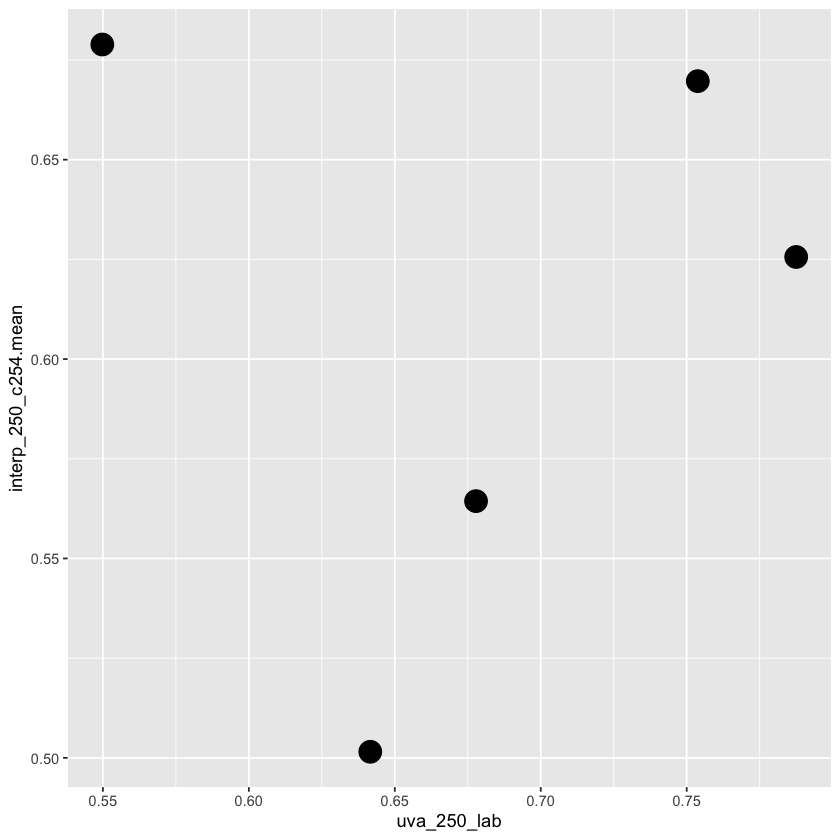

In [34]:
suna_grab<-subset(suna_grab,uva_250_lab>0.1 & a254.mean<7 & !is.na(turbidity.mean))

suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)

#suna_grab$turb_log
summary(lm(uva_250_lab~a254.mean*turb_log,suna_grab))
summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))
summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

#suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
#suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))

suna_grab[,c("uva_250_lab","interp_250_c254.mean")]
ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean))+
#theme_ts_space+
#xlab("\nUV Absorbance at 250 nm (Laboratory)")+
#ylab("UV Absorbance at 250 nm (SUNA Uncorrected)\n")+
geom_point(size=6)




Call:
lm(formula = uva_250_lab ~ interp_250_log * turb_log, data = suna_grab)

Residuals:
         2          3          4          5          6 
-0.0991070  0.0027356  0.1052791 -0.0087959 -0.0001118 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)
(Intercept)              0.52658    0.80657   0.653    0.632
interp_250_log          -0.27510    3.47257  -0.079    0.950
turb_log                 0.09591    1.18062   0.081    0.948
interp_250_log:turb_log  0.01257    5.52364   0.002    0.999

Residual standard error: 0.1449 on 1 degrees of freedom
Multiple R-squared:  0.4072,	Adjusted R-squared:  -1.371 
F-statistic: 0.229 on 3 and 1 DF,  p-value: 0.8722



Call:
lm(formula = uva_250_lab ~ interp_250_c254.mean * turb_log, data = suna_grab)

Residuals:
         2          3          4          5          6 
-0.0986230  0.0028380  0.1055041 -0.0095914 -0.0001277 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)
(Intercept)                    0.71249    1.57450   0.453    0.729
interp_250_c254.mean          -0.20585    2.65155  -0.078    0.951
turb_log                       0.08652    2.51873   0.034    0.978
interp_250_c254.mean:turb_log  0.01003    4.10568   0.002    0.998

Residual standard error: 0.1448 on 1 degrees of freedom
Multiple R-squared:  0.4082,	Adjusted R-squared:  -1.367 
F-statistic: 0.2299 on 3 and 1 DF,  p-value: 0.8717


`geom_smooth()` using formula 'y ~ x'



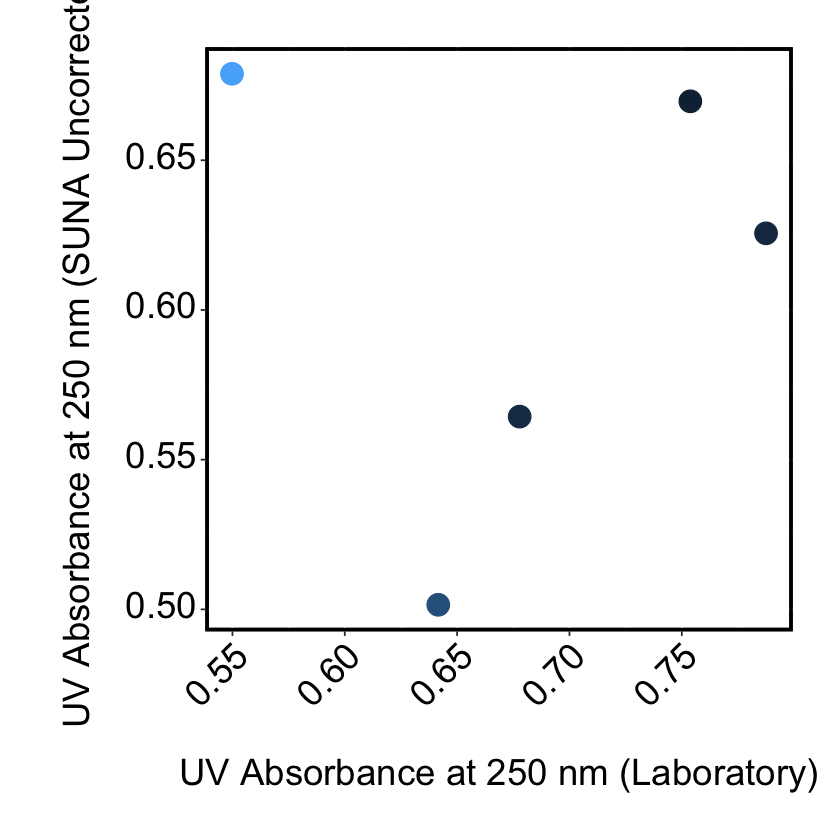

`geom_smooth()` using formula 'y ~ x'



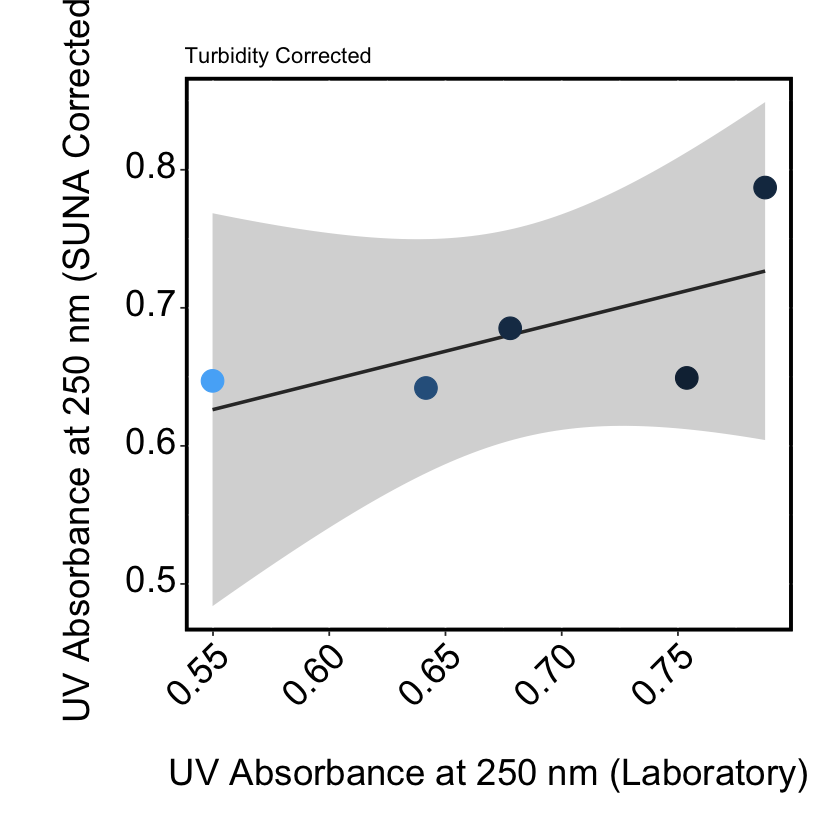

In [35]:
suna_grab$interp_250_log<-log10(suna_grab$interp_250_c254.mean)
suna_grab$turb_log<-log10(suna_grab$turbidity.mean)


summary(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))
summary(lm(uva_250_lab~interp_250_c254.mean*turb_log,suna_grab))

suna_grab$interp_250_tcorr<-predict(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log<-predict(lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab))
suna_grab$interp_250_tcorr_log_turb<-predict(lm(uva_250_lab~interp_250_log*turb_log,suna_grab))


ggplot(suna_grab,aes(uva_250_lab,interp_250_c254.mean,color=pH.mean))+
theme_ts_space+
xlab("\nUV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Uncorrected)\n")+
geom_point(size=6)

ggsave("~/neon_suna/plots/PLRA_250_uncorrected.pdf",width = 20, height = 20, units = "cm")



ggplot(suna_grab,aes(uva_250_lab,interp_250_tcorr_log,color=pH.mean))+
theme_ts_space+
geom_smooth(method="lm",color="grey20")+
xlab("\nUV Absorbance at 250 nm (Laboratory)")+
ylab("UV Absorbance at 250 nm (SUNA Corrected)\n")+
geom_point(size=6)+
ggtitle("Turbidity Corrected")

ggsave("~/neon_suna/plots/PLRA_250_corrected.pdf",width = 20, height = 20, units = "cm")




#summary(lm(uva_250_lab~interp_250_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c350.mean*turbidity.mean+sensor_temp.mean,suna_grab))
#summary(lm(uva_280_lab~interp_280_c254.mean*turbidity.mean+sensor_temp.mean,suna_grab))

In [36]:
head(suna_grab)

,dtpr,nitrate.mean,nitrate_mgl.mean,a254.mean,a350.mean,sensor_temp.mean,interp_189.mean,interp_190.mean,interp_191.mean,interp_192.mean,⋯,turbidity.mean,fDOM.mean,collectDate,uva_250_lab,uva_280_lab,interp_250_log,turb_log,interp_250_tcorr,interp_250_tcorr_log,interp_250_tcorr_log_turb
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,2019-06-04 15:30:00,45.5755,0.638340,0.649805,0.117395,19.420,-Inf,NaN,-8.802532,6.920253,⋯,6.470000,107.420000,2019-06-04 15:25:00,0.5498000,0.2846000,-0.1682066,0.8109043,0.6465865,0.6470872,0.6489070
3,2019-07-01 15:00:00,38.4495,0.538555,0.587875,0.064345,22.530,-Inf,NaN,-10.752215,7.111076,⋯,146.406667,9.046667,2019-07-01 14:53:00,0.7875000,0.4116667,-0.2037034,2.1655609,0.7870975,0.7871119,0.7847644
4,2019-08-06 16:00:00,49.4670,0.692870,0.636465,0.105475,23.960,-28.20,-1.201875,26.372785,NaN,⋯,6.166667,83.100000,2019-08-06 15:55:00,0.7538000,0.3852000,-0.1741264,0.7900505,0.6490288,0.6492254,0.6485209
5,2019-09-04 16:00:00,80.2970,1.124725,0.542350,0.049405,17.095,-21.10,-0.859375,19.772152,NaN,⋯,9.736667,37.046667,2019-09-04 16:00:00,0.6778333,0.3498000,-0.2484293,0.9884103,0.6858380,0.6851757,0.6866292
6,2019-10-16 17:00:00,49.6040,0.694800,0.493895,0.054580,2.220,-15.95,-0.044375,16.459494,NaN,⋯,2.263333,83.926667,2019-10-16 17:05:00,0.6416000,0.3293000,-0.2997035,0.3547485,0.6419825,0.6419331,0.6417118


In [ ]:
names(PLRA_sw)

# Apply turbidity correction based on lab samples.

In [ ]:
cor_cols<-grep("^interp_",names(PLRA_sw))

uva_250_turb_lm<-lm(uva_250_lab~interp_250_log*turbidity.mean,suna_grab)

for(i in 1:length(cor_cols)){
	prepdata<-data.frame(interp_250_log=log10(PLRA_sw[,cor_cols[i]]),turbidity.mean=PLRA_sw$turbidity.mean)
	turb_cor_pred<-predict(uva_250_turb_lm,newdata=prepdata)
	PLRA_sw[,c(paste(names(PLRA_sw)[cor_cols[i]],"_turb",sep=""))]<-turb_cor_pred
}



In [ ]:
head(PLRA_sw)

In [ ]:
PLRA_swt_0<-PLRA_sw[,grep("*_turb$",names(PLRA_sw))]
PLRA_swt<-bind_cols(PLRA_sw[,c("dtpr","nitrate.mean","nitrate_mgl.mean","a254.mean","a350.mean","sensor_temp.mean","specificConductance.mean","dissolvedOxygen.mean","pH.mean","chlorophyll.mean","turbidity.mean","fDOM.mean")],PLRA_swt_0)





# Adding PAR data.

In [ ]:
PLRA_par<-loadByProduct(dpID="DP1.20042.001",site="PLRA",check.size=F)
saveRDS(PLRA_par,paste(getwd(),"/PLRA_par.rds",sep=""))
PLRA_par<-readRDS(paste(getwd(),"/PLRA_par.rds",sep=""))




In [ ]:
#lubridate::round_date(PLRA_parts$dtp, "15 minutes")


In [ ]:

PLRA_parts<-PLRA_par$PARWS_5min
PLRA_parts$dtp<-PLRA_parts$startDateTime
#str(PLRA_wqk)



PLRA_parts$dtpr<-lubridate::round_date(PLRA_parts$dtp, "15 minutes")
PLRA_parts_red<-summaryBy(PARMean~dtpr,PLRA_parts,FUN=c(mean))
head(PLRA_parts_red)
#str(PLRA_wq_red)

PLRA_swtpar<-merge(PLRA_swt,PLRA_parts_red,by="dtpr",all.x=TRUE)


In [ ]:

str(PLRA_swtpar$dtpr)

attr(PLRA_swtpar$dtpr,"tzone") <- "Etc/GMT+5"

str(PLRA_swtpar$dtpr)
PLRA_swtpar$date<-as.Date(PLRA_swtpar$dtpr,tz="Etc/GMT+5")

PLRA_dates<-unique(PLRA_swtpar$date)

for(i in 1:length(PLRA_dates)){
    
    
}

In [ ]:

#PLRAd<-subset(PLRA_swtpar,date==as.Date("2019-06-10"))
PLRAd<-PLRA_swtpar

PLRAdk<-PLRAd[,grep("*c254.mean_turb$",names(PLRAd))]
PLRAdk$dtpr<-PLRAd$dtpr

PLRAdm<-subset(melt(PLRAdk,id.vars=c("dtpr")),!is.na(value))
PLRAdm$wavelength<-gsub("interp_","",PLRAdm$variable,fixed=TRUE)
PLRAdm$wavelength<-as.numeric(gsub("_c254.mean_turb","",PLRAdm$wavelength,fixed=TRUE))



str(PLRAdm)

# Trying some ridge plots to look at wavelength changes over time.
So far not looPLRA super great.

In [ ]:
#library(ggridges)
#scales::rescale(height)
#PLRAdm$dtprn<-scales::rescale(as.numeric(PLRAdm$dtpr))
#PLRAdm$abs<-scales::rescale(as.numeric(PLRAdm$value))


#ggplot(subset(PLRAdm,wavelength>=275&wavelength<=295),aes(x = wavelength, y = dtprn, group=dtprn,height = abs)) +
#  geom_ridgeline(fill="grey80",alpha=0.6)

#ggsave("~/neon_suna/plots/PLRAdm_ridge.pdf",width = 20, height = 40, units = "cm")


# Calculating spectral slope 275-295nm on each time step.

In [ ]:
names(PLRAd)
names(PLRAdm)

In [ ]:
ssm_275_295<-subset(PLRAdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()


for(i in 1:length(dtps)){
	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()
}	
	


In [ ]:
ggplot(subset(ssm_275_295,variable=="interp_275_c254.mean_turb"),aes(dtpr,value))+geom_point()


In [ ]:
ssm_275_295<-subset(PLRAdm,wavelength>=275&wavelength<=295)
dtps<-unique(ssm_275_295$dtpr)
pb <- progress_bar$new(
	format = "  downloading [:bar] :percent eta: :eta",
	total = length(dtps), clear = FALSE, width= 60)
s275295_comp<-data.frame()



	ssm_now<-subset(ssm_275_295,dtpr==dtps[i])
	
	ssm_now$am1<-ssm_now$value*100*2.3025851
	ssm_now$lnam1<-log(ssm_now$am1)


	if(sum(!is.na(ssm_now$lnam1))>2){
		s275295<-lm(ssm_now$lnam1~ssm_now$wavelength)$coefficients[2]*-1
		}else{s275295<-NA}
		s275295_temp<-data.frame(dtpr=dtps[i],s275295=s275295)
		s275295_comp<-bind_rows(s275295_comp,s275295_temp)
#		pb$tick()


In [ ]:
nrow(s275295_comp)
nrow(PLRA_swtpar)
PLRA_swtp_ss<-merge(PLRA_swtpar,s275295_comp,by="dtpr",all.x=TRUE)
saveRDS(PLRA_swtp_ss,paste(data,"PLRA_swtp_ss.rds",sep=""))

In [ ]:
sdates<-unique(as.Date(PLRA_swtp_ss$dtpr,tz="Etc/GMT+5"))

i<-5
comp_df<-data.frame()
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
PLRAday<-subset(PLRA_swtp_ss,dtpr>=start & dtpr<=finish)
PLRAday<-subset(PLRAday,!is.na(PARMean.mean) & !is.na(s275295))
nrow(PLRAday)
    PLRAday$PAR_roll<-as.numeric(c("NA",rollmean(PLRAday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    PLRAday$s275295_roll<-as.numeric(c("NA",rollmean(PLRAday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    PLRA_night<-subset(PLRAday,PARMean.mean<200)
    night_s275295<-mean(PLRA_night$s275295,na.rm=TRUE)

    
    #PLRAday$baseline<-predict(lm(s275295~dtpr,PLRA_night),PLRAday)
    PLRAday$baseline_roll<-predict(lm(s275295_roll~dtpr,PLRA_night),PLRAday)    
    PLRAday$s275295_bs<-PLRAday$s275295_roll-PLRAday$baseline_roll    
    
    PLRA_night_am<-subset(PLRA_night,hour(dtpr)<=12)
    night_s275295_am<-mean(PLRA_night_am$s275295,na.rm=TRUE)
    
    PLRA_night_pm<-subset(PLRA_night,hour(dtpr)>12)
    night_s275295_pm<-mean(PLRA_night_pm$s275295,na.rm=TRUE)
    
    PLRA_day<-subset(PLRAday,PARMean.mean>=10)
    day_s275295<-mean(PLRA_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(PLRA_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(PLRA_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,PLRA_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,PLRA_day)$coef[2]    
    
    PLRA_n_am_time<-nrow(PLRA_night_am)
    PLRA_n_pm_time<-nrow(PLRA_night_pm)
    PLRA_d_time<-nrow(PLRA_day)
    
    temp_df<-data.frame(site="PLRA",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,PLRA_n_am_time=PLRA_n_am_time,PLRA_n_pm_time=PLRA_n_pm_time,PLRA_d_time=PLRA_d_time)

# Extracting spectral daily slope ratio discrepancy.

In [ ]:
sdates<-unique(as.Date(PLRA_swtp_ss$dtpr,tz="Etc/GMT+5"))

#i<-30
comp_df<-data.frame()
for(i in 1:length(sdates)){
#print(i)
start<-as.POSIXct(paste(sdates[i]-1,"22:00",tz="Etc/GMT+5"))
finish<-as.POSIXct(paste(sdates[i]+1,"03:00",tz="Etc/GMT+5"))
PLRAday<-subset(PLRA_swtp_ss,dtpr>=start & dtpr<=finish)
PLRAday<-subset(PLRAday,!is.na(PARMean.mean) & !is.na(s275295))

if(nrow(PLRAday)>80){
    PLRAday$PAR_roll<-as.numeric(c("NA",rollmean(PLRAday$PARMean.mean,k=3,align=c("center"),na.fill=TRUE),"NA"))
    PLRAday$s275295_roll<-as.numeric(c("NA",rollmean(PLRAday$s275295,k=3,align=c("center"),na.fill=TRUE),"NA"))



    PLRA_night<-subset(PLRAday,PARMean.mean<200)
    night_s275295<-mean(PLRA_night$s275295,na.rm=TRUE)
    
    #PLRAday$baseline<-predict(lm(s275295~dtpr,PLRA_night),PLRAday)
    PLRAday$baseline_roll<-predict(lm(s275295_roll~dtpr,PLRA_night),PLRAday)    
    PLRAday$s275295_bs<-PLRAday$s275295_roll-PLRAday$baseline_roll    
    
    PLRA_night_am<-subset(PLRA_night,hour(dtpr)<=12)
    night_s275295_am<-mean(PLRA_night_am$s275295,na.rm=TRUE)
    
    PLRA_night_pm<-subset(PLRA_night,hour(dtpr)>12)
    night_s275295_pm<-mean(PLRA_night_pm$s275295,na.rm=TRUE)
    
    PLRA_day<-subset(PLRAday,PARMean.mean>=10)
    day_s275295<-mean(PLRA_day$s275295,na.rm=TRUE)

    day_s275295_base_sum<-sum(PLRA_day$s275295_bs,na.rm=TRUE)
    day_PAR_roll_base_sum<-sum(PLRA_day$PAR_roll,na.rm=TRUE)    

    int<-lm(s275295_bs~PAR_roll,PLRA_day)$coef[1]
    slope<-lm(s275295_bs~PAR_roll,PLRA_day)$coef[2]    
    
    PLRA_n_am_time<-nrow(PLRA_night_am)
    PLRA_n_pm_time<-nrow(PLRA_night_pm)
    PLRA_d_time<-nrow(PLRA_day)
    
    temp_df<-data.frame(site="PLRA",date=sdates[i],night_s275295=night_s275295,night_s275295_am=night_s275295_am,night_s275295_pm=night_s275295_pm,day_s275295=day_s275295,day_s275295_base_sum=day_s275295_base_sum,day_PAR_roll_base_sum=day_PAR_roll_base_sum,int=int,slope=slope,PLRA_n_am_time=PLRA_n_am_time,PLRA_n_pm_time=PLRA_n_pm_time,PLRA_d_time=PLRA_d_time)
    comp_df<-bind_rows(comp_df,temp_df)
    }
}




In [ ]:
nrow(comp_df)
head(comp_df)

In [ ]:
    PLRA_day$s275295_bs
ggplot(comp_df,aes(date,day_s275295_base_sum))+
       geom_point(size=2)
ggplot(comp_df,aes(date,day_PAR_roll_base_sum))+
       geom_point(size=2)


ggplot(comp_df,aes(day_PAR_roll_base_sum,day_s275295_base_sum))+
geom_point()


saveRDS(comp_df,paste(data,"comp_df_PLRA.rds",sep=""))

In [ ]:
PLRAday<-subset(PLRA_swtp_ss,as.Date(dtpr,tz="Etc/GMT+5")==as.Date("2019-06-11",tz="Etc/GMT+5"))
nrow(PLRAday)

str(PLRAday$s275295)



ggplot(PLRAday,aes(dtpr,s275295))+
geom_point()


ggplot(PLRAday,aes(dtpr,PARMean.mean))+
geom_point()

ggplot(PLRAday,aes(dtpr,PARMean.mean))+
geom_point()

